In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
path = '../../../data/miner/'
data = '09517617000153_3.csv'
df   = pd.read_csv(path + data, encoding="utf-8", dtype=str)
df[["data"]] = df[["data"]].apply(pd.to_datetime)
df[["quantidade"]] = df[["quantidade"]].apply(pd.to_numeric)
id_produto = '138352'
id_produto = '80354'
df    = (df[df['produtoId']== id_produto])


In [3]:
df.head()

,data,produtoId,descr,valor,quantidade,valorCancelado,quantidadeCancelada,quantidadeDocumentos,quantidadeValorZero
2416,2019-01-02,80354,CAFE SANTA CLARA VC 250G PREMIUM,635.32,148.0,0.0,0.0,67,0.0
5395,2019-01-03,80354,CAFE SANTA CLARA VC 250G PREMIUM,523.38,122.0,0.0,0.0,52,0.0
8184,2019-01-04,80354,CAFE SANTA CLARA VC 250G PREMIUM,613.47,143.0,8.58,2.0,77,0.0
11022,2019-01-05,80354,CAFE SANTA CLARA VC 250G PREMIUM,626.34,146.0,30.03,7.0,72,0.0
13675,2019-01-06,80354,CAFE SANTA CLARA VC 250G PREMIUM,570.57,133.0,0.0,0.0,64,0.0


In [4]:
df    = (df[df['produtoId']== id_produto])
df = df.rename(columns={'data': 'time', 'quantidade': 'data'})
df = df[['time','data']]

In [5]:
df.head()

,time,data
2416,2019-01-02,148.0
5395,2019-01-03,122.0
8184,2019-01-04,143.0
11022,2019-01-05,146.0
13675,2019-01-06,133.0


In [6]:
df.describe()

,data
count,425.000000
mean,90.672941
std,57.670002
min,7.000000
25%,51.000000
50%,78.000000
75%,115.000000
max,432.000000


In [7]:
df_ts = df

df_ts = df_ts[['data', 'time']]

df_ts.columns = ['y', 'ds']

df_ts.head()


,y,ds
2416,148.0,2019-01-02
5395,122.0,2019-01-03
8184,143.0,2019-01-04
11022,146.0,2019-01-05
13675,133.0,2019-01-06


In [8]:
df_ts.describe()

,y
count,425.000000
mean,90.672941
std,57.670002
min,7.000000
25%,51.000000
50%,78.000000
75%,115.000000
max,432.000000


In [9]:
%matplotlib inline
plt.style.use('Solarize_Light2')

In [10]:
df = df.set_index('time')
df_mahalanobis = df

In [11]:
df.head()

,data
time,
2019-01-02,148.0
2019-01-03,122.0
2019-01-04,143.0
2019-01-05,146.0
2019-01-06,133.0


In [12]:
df.describe()

,data
count,425.000000
mean,90.672941
std,57.670002
min,7.000000
25%,51.000000
50%,78.000000
75%,115.000000
max,432.000000


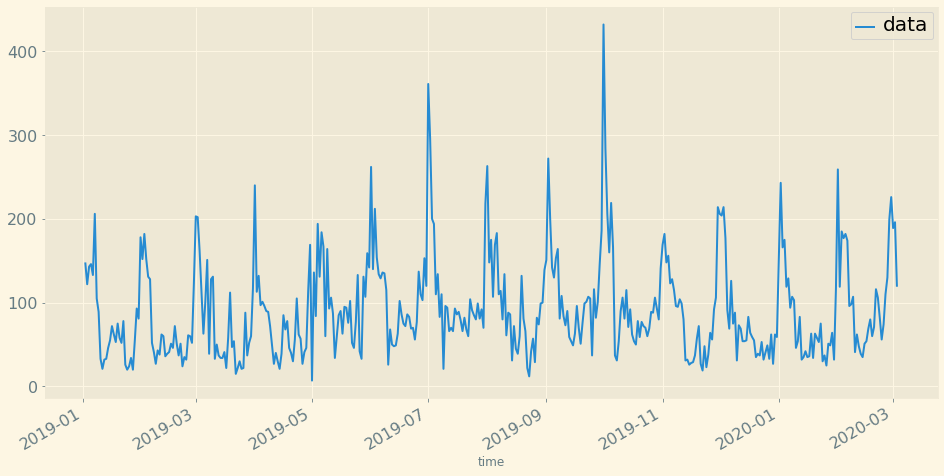

In [13]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
df.plot(ax=ax, fontsize=16);
legend = ax.get_legend()
legend.prop.set_size(20);

In [14]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [15]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast

Displaying Prophet plot


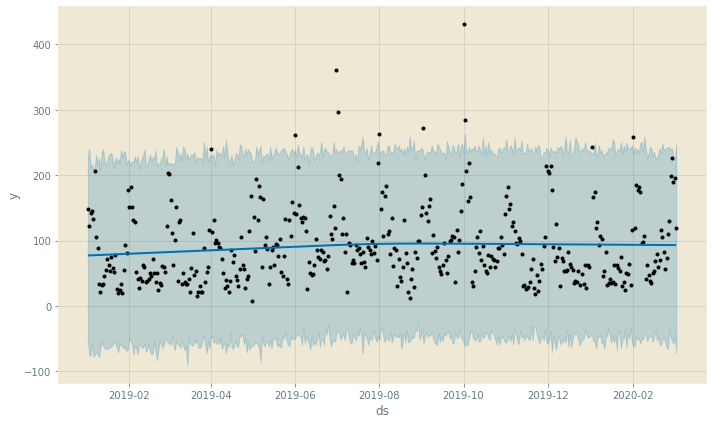

In [16]:
pred = fit_predict_model(df_ts)

In [17]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

anom = detect_anomalies(pred)

In [18]:
anom.describe()

,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,90.627898,90.627898,-52.721303,234.927583,90.672941,0.023529,0.003761
std,5.500535,5.500535,10.009297,9.622495,57.670002,0.151756,0.031590
min,77.305284,77.305284,-91.244283,207.575374,7.000000,0.000000,0.000000
25%,86.797272,86.797272,-59.254518,229.637315,51.000000,0.000000,0.000000
50%,93.563142,93.563142,-52.354529,235.076406,78.000000,0.000000,0.000000
75%,94.765507,94.765507,-45.977562,241.044429,115.000000,0.000000,0.000000
max,95.569208,95.569208,-23.391372,263.238396,432.000000,1.000000,0.461654


In [19]:
anom = anom[anom.anomaly != 0]

In [20]:
anom

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
89,2019-04-01,85.274971,85.274971,-48.775345,232.408974,240.0,1,0.031629
150,2019-06-01,90.736003,90.736003,-50.010825,238.675028,262.0,1,0.089027
180,2019-07-01,93.294305,93.294305,-40.471324,240.433648,361.0,1,0.333979
181,2019-07-02,93.364885,93.364885,-37.618584,232.825900,296.0,1,0.213426
211,2019-08-01,95.054150,95.054150,-52.498417,234.672186,263.0,1,0.107710
243,2019-09-02,95.564313,95.564313,-57.604819,232.909739,272.0,1,0.143714
272,2019-10-01,95.282184,95.282184,-55.015058,232.565643,432.0,1,0.461654
273,2019-10-02,95.268622,95.268622,-61.255758,263.238396,284.0,1,0.073104
363,2020-01-02,94.014029,94.014029,-44.453447,233.168019,243.0,1,0.040461
393,2020-02-01,93.604132,93.604132,-62.242597,232.157357,259.0,1,0.103640


In [21]:
anom = anom.set_index('ds')

In [22]:
len(anom)

10

In [23]:
list_an = anom.index

In [24]:
list_an

DatetimeIndex(['2019-04-01', '2019-06-01', '2019-07-01', '2019-07-02',
               '2019-08-01', '2019-09-02', '2019-10-01', '2019-10-02',
               '2020-01-02', '2020-02-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [25]:
df = df.drop(list_an)
df.head()

,data
time,
2019-01-02,148.0
2019-01-03,122.0
2019-01-04,143.0
2019-01-05,146.0
2019-01-06,133.0


In [26]:
df.describe()

,data
count,415.000000
mean,85.840964
std,48.294125
min,7.000000
25%,50.000000
50%,76.000000
75%,111.000000
max,226.000000


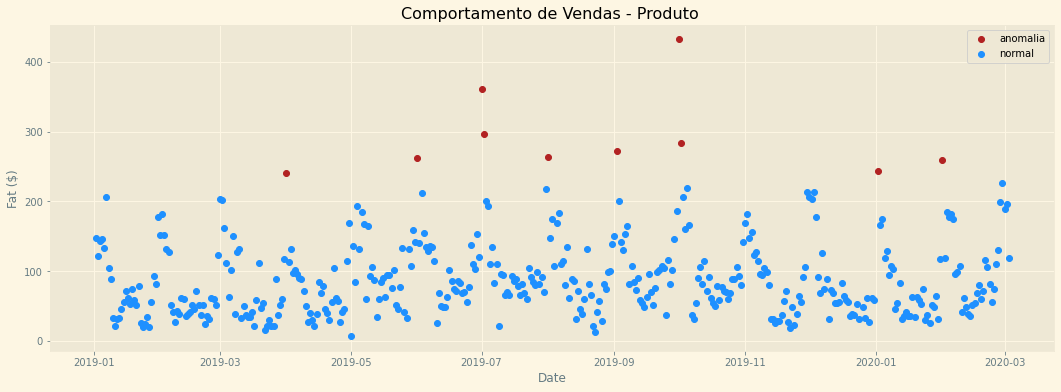

In [27]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(anom.index.values, anom['fact'], color='firebrick', label='anomalia')
ax.scatter(df.index.values, df['data'], color='dodgerblue', label = 'normal')

ax.set(xlabel="Date", ylabel="Fat ($)",
       title="Comportamento de Vendas - Produto ")

ax.legend(loc="upper right")
plt.show()

In [28]:
from scipy.spatial import distance
import scipy as sp

In [29]:
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [30]:
df_mahalanobis.head()

,data
time,
2019-01-02,148.0
2019-01-03,122.0
2019-01-04,143.0
2019-01-05,146.0
2019-01-06,133.0


In [31]:
df_mahalanobis.describe()

,data
count,425.000000
mean,90.672941
std,57.670002
min,7.000000
25%,51.000000
50%,78.000000
75%,115.000000
max,432.000000


In [32]:
df_mahalanobis[["data"]]  = df_mahalanobis[["data"]].apply(pd.to_numeric)
df_mahalanobis['id'] = range(1, 1+len(df_mahalanobis))

In [33]:
df_mahalanobis['mahala'] = mahalanobis(x=df_mahalanobis, data=df_mahalanobis)

In [34]:
df_mahalanobis.describe()

,data,id,mahala
count,425.000000,425.000000,425.000000
mean,90.672941,213.000000,1.995294
std,57.670002,122.831185,2.572635
min,7.000000,1.000000,0.001720
25%,51.000000,107.000000,0.637388
50%,78.000000,213.000000,1.614896
75%,115.000000,319.000000,2.621800
max,432.000000,425.000000,35.030397


In [35]:
df_in = df_mahalanobis.loc[df_mahalanobis['mahala'] <= (df_mahalanobis['mahala'].mean() + 
                                                        df_mahalanobis['mahala'].std() + df_mahalanobis['mahala'].describe().iloc[6])] #+df['mahala'].describe().iloc[5])]

In [36]:
print(len(df_mahalanobis), len(df_in))

425 413


In [37]:
418 - 369

49

In [38]:
list_in = df_in.index

In [39]:
df.index

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-07', '2019-01-08', '2019-01-09',
               '2019-01-10', '2019-01-11',
               ...
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', name='time', length=415, freq=None)

In [40]:
list_in

DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-05',
               '2019-01-06', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-12',
               ...
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
               '2020-02-26', '2020-02-27', '2020-02-28', '2020-03-01',
               '2020-03-02', '2020-03-03'],
              dtype='datetime64[ns]', name='time', length=413, freq=None)

In [41]:
df_out = df_mahalanobis.drop(list_in)

In [42]:
columns = ['mahala','id']
df_out.drop(columns, inplace=True, axis=1)

In [43]:
columns = ['mahala','id']
df_in.drop(columns, inplace=True, axis=1)


/home/dev/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


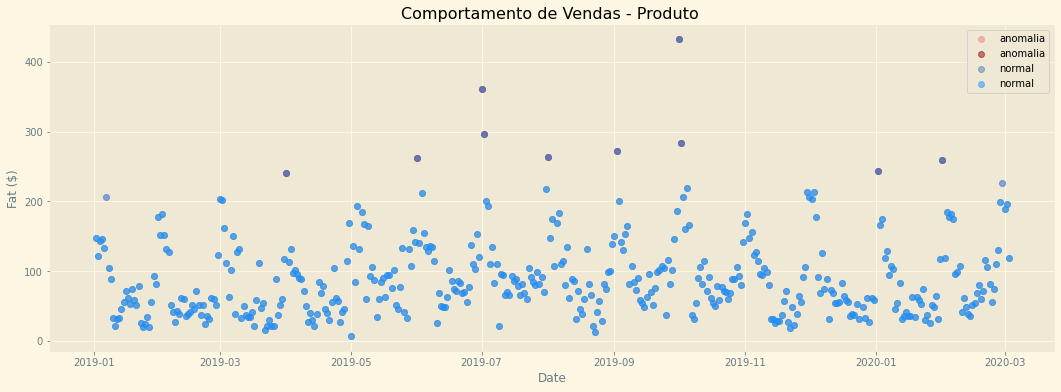

In [44]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(df_out.index.values, df_out['data'], color='lightcoral', label='anomalia', alpha=0.5)
ax.scatter(anom.index.values,   anom['fact'], color='darkred', label='anomalia', alpha=0.5)
ax.scatter(df_in.index.values,  df_in['data'], color='steelblue', label = 'normal' , alpha=0.5)
ax.scatter(df_mahalanobis.index.values,   df_mahalanobis['data'], color='dodgerblue', label = 'normal', alpha=0.5)
ax.set(xlabel="Date", ylabel="Fat ($)",
       title="Comportamento de Vendas - Produto ")

ax.legend(loc="upper right")

plt.show()

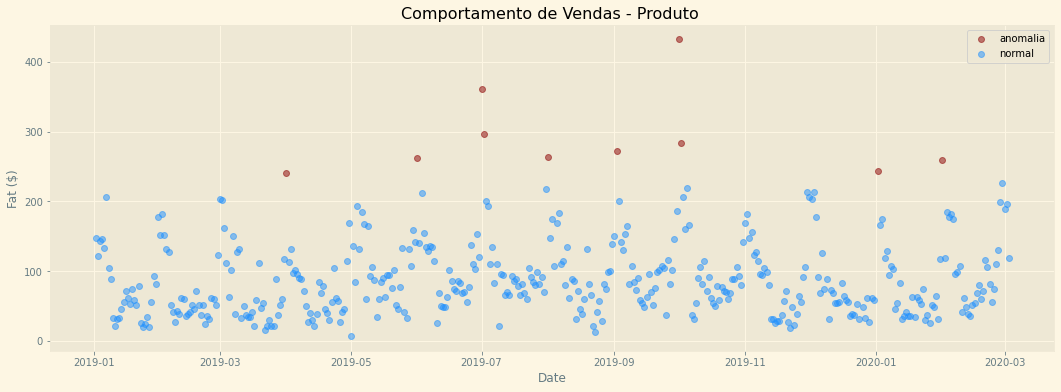

In [45]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(anom.index.values,   anom['fact'], color='darkred', label='anomalia', alpha=0.5)
ax.scatter(df.index.values,     df['data'], color='dodgerblue', label = 'normal', alpha=0.5)
ax.set(xlabel="Date", ylabel="Fat ($)",
       title="Comportamento de Vendas - Produto ")

ax.legend(loc="upper right")

plt.show()

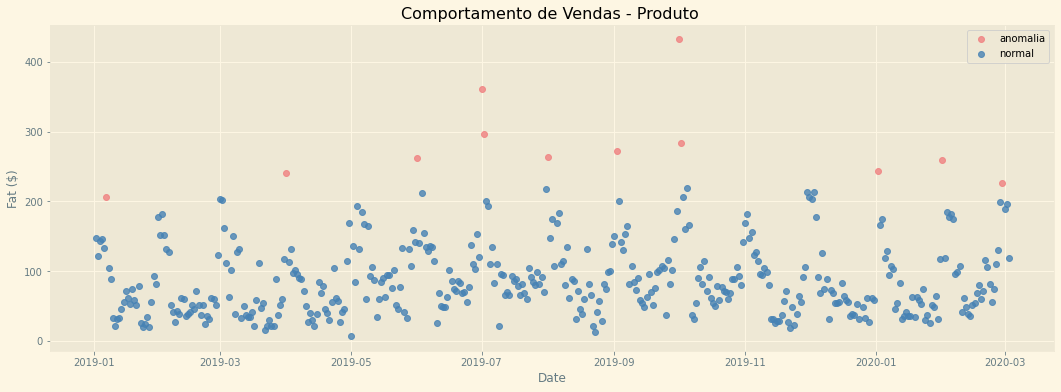

In [46]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.scatter(df_out.index.values, df_out['data'], color='lightcoral', label='anomalia', alpha=0.8)
ax.scatter(df_in.index.values,  df_in['data'], color='steelblue', label = 'normal' , alpha=0.8)
ax.set(xlabel="Date", ylabel="Fat ($)",
       title="Comportamento de Vendas - Produto ")

ax.legend(loc="upper right")

plt.show()